In [3]:
# Basic data manipulation and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os

# Network Libraries
import networkx as nx
import community

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set up paths
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f'{curr_dir}/results'

def load_matrices_simple(results_dir, n_rois=200):
    """
    Load and average connectivity matrices
    """
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}_standard/*_connectivity_matrix_standard.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    return matrix

# Load data
matrix = load_matrices_simple(results_dir)

Found 18 connectivity matrices


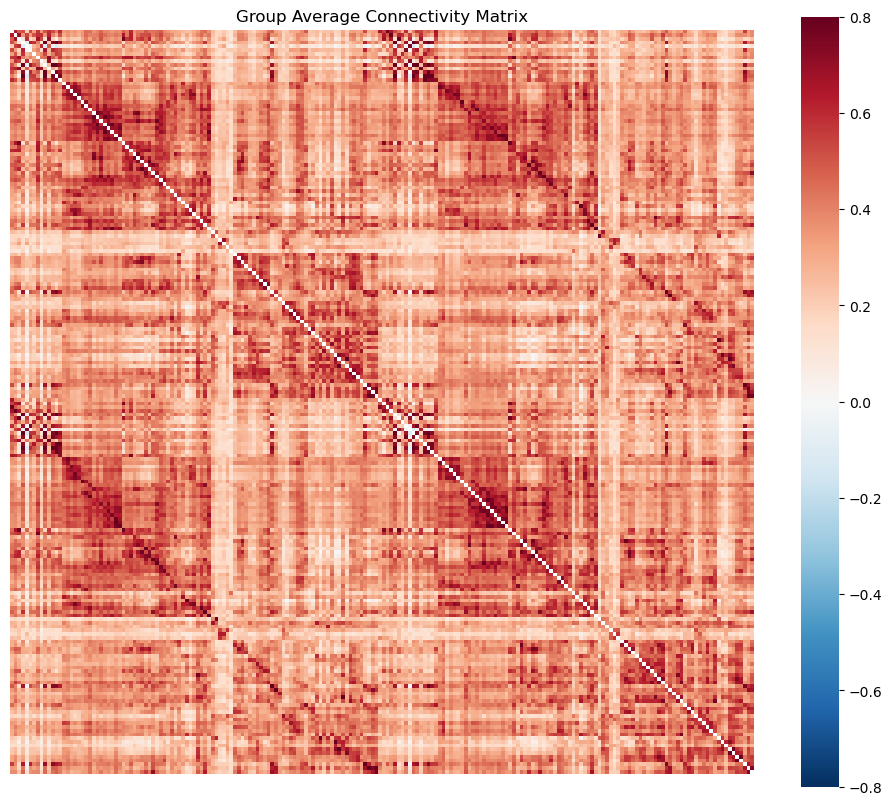

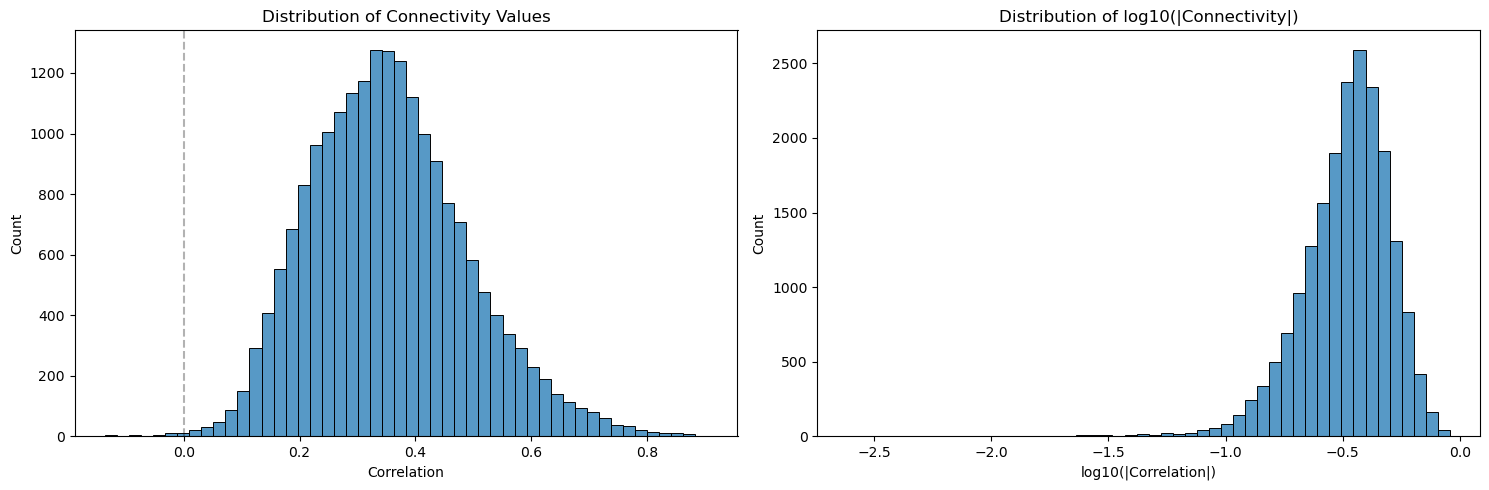


Connectivity Statistics:
Mean correlation: 0.354
Standard deviation: 0.136
Min correlation: -0.137
Max correlation: 0.905


In [6]:
# Create basic visualization of average connectivity matrix
plt.figure(figsize=(12, 10))
matrix_plot = matrix.copy()
np.fill_diagonal(matrix_plot, np.nan)  # Remove diagonal for better visualization

sns.heatmap(matrix_plot, 
            cmap='RdBu_r',  # Red-Blue colormap: red for positive, blue for negative
            center=0,
            vmin=-0.8,
            vmax=0.8,
            square=True,
            xticklabels=False,
            yticklabels=False)
plt.title('Group Average Connectivity Matrix')
plt.show()

# Let's create both distribution plots properly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Get lower triangle values (excluding diagonal)
mask = np.triu(np.ones(matrix.shape)).astype(bool)
flat_matrix = matrix[~mask]

# Raw distribution
sns.histplot(flat_matrix, bins=50, ax=ax1)
ax1.set_title('Distribution of Connectivity Values')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Count')
ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Log distribution of absolute values
log_matrix = np.log10(np.abs(flat_matrix[flat_matrix != 0]))  # Avoid log(0)
sns.histplot(log_matrix, bins=50, ax=ax2)
ax2.set_title('Distribution of log10(|Connectivity|)')
ax2.set_xlabel('log10(|Correlation|)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics
print("\nConnectivity Statistics:")
print(f"Mean correlation: {np.mean(flat_matrix):.3f}")
print(f"Standard deviation: {np.std(flat_matrix):.3f}")
print(f"Min correlation: {np.min(flat_matrix):.3f}")
print(f"Max correlation: {np.max(flat_matrix):.3f}")

In [5]:
def create_network_analysis(matrix, threshold=0.4):
    """
    Create and analyze network at given threshold
    """
    # Create thresholded matrix
    matrix_thresh = matrix.copy()
    matrix_thresh[matrix_thresh <= threshold] = 0
    
    # Create network
    G = nx.from_numpy_array(matrix_thresh)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Calculate basic network metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    
    # Calculate node centrality measures
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    
    # Find top 10 nodes by degree centrality
    top_nodes = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]
    
    return G, {
        'n_nodes': n_nodes,
        'n_edges': n_edges,
        'density': density,
        'top_nodes': top_nodes
    }

# Let's try with our middle threshold first
G, metrics = create_network_analysis(matrix, threshold=0.4)

# Print basic metrics
print(f"\nNetwork Analysis (threshold = 0.4):")
print(f"Number of nodes: {metrics['n_nodes']}")
print(f"Number of edges: {metrics['n_edges']}")
print(f"Network density: {metrics['density']:.3f}")
print("\nTop 10 nodes by degree centrality:")
for node, centrality in metrics['top_nodes']:
    print(f"Node {node}: {centrality:.3f}")


Network Analysis (threshold = 0.4):
Number of nodes: 200
Number of edges: 6748
Network density: 0.339

Top 10 nodes by degree centrality:
Node 40: 0.663
Node 135: 0.653
Node 144: 0.653
Node 21: 0.628
Node 145: 0.618
Node 156: 0.618
Node 28: 0.613
Node 52: 0.603
Node 41: 0.598
Node 155: 0.598
